In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# E(Y | do(X), Z) are continuous, so we are in the hypotheses of the RDD method.

def ground_truth_X_false(Z):
    """E(Y | do(X=0), Z)."""
    return 2 + 3 * Z

def ground_truth_X_true(Z):
    """E(Y | do(X=1), Z)."""
    return 4 + 5 * Z

def generate_truth_X_Z(X, Z):
    """E(Y | do(X), Z)."""
    return np.select([X, ~X], [ground_truth_X_true(Z), ground_truth_X_false(Z)])

def generate_noise(size, random_state=None):
    """Zero mean random noise."""
    return np.random.RandomState(random_state).normal(0, 1, size=size)

def generate_data(size, z1, random_state=None):
    """Data generation process."""
    rs = np.random.RandomState(random_state).randint(0, 2**32 - 1, size=2, dtype=np.int64)
    Z = np.random.RandomState(rs[0]).normal(0, 1, size=size)
    X = (Z > z1)
    Y = generate_truth_X_Z(X, Z) + generate_noise(size=size, random_state=rs[1])
    return Z, X, Y

In [3]:
size = 500
z1 = 0
Z, X, Y = generate_data(size=size, z1=z1, random_state=42)

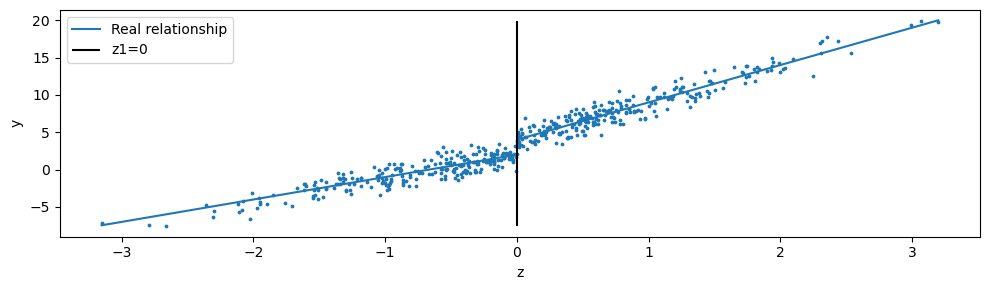

In [4]:
min_Z, max_Z = min(Z), max(Z)
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(Z, Y, s=3)
plot_Z = np.linspace(min_Z, max_Z, 1001)
plot_X = (plot_Z > z1)
plot_Y = generate_truth_X_Z(plot_X, plot_Z)
ax.plot(plot_Z[plot_X], plot_Y[plot_X], "C0", label="Real relationship")
ax.plot(plot_Z[~plot_X], plot_Y[~plot_X], "C0")
ax.vlines(z1, min(Y), max(Y), "k", label=f"{z1=}")
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.legend()
plt.tight_layout()

In [5]:
from sklearn.linear_model import LinearRegression
lr_X_false = LinearRegression().fit(Z[~X].reshape(-1, 1), Y[~X])
lr_X_true = LinearRegression().fit(Z[X].reshape(-1, 1), Y[X])

In [6]:
print("Point estimation of ACE with proposed method:", lr_X_true.predict(Z.reshape(-1, 1)).mean() - lr_X_false.predict(Z.reshape(-1, 1)).mean())

Point estimation of ACE with proposed method: 1.9809454783634948


In [7]:
def estimate_effect_with_bootstrap(model, X, Y, Z):
    estimations = []
    for i in tqdm(range(100)):
        
        ind = np.random.RandomState(i).choice(a=len(Z), size=len(Z))
        Z_bootstrap = Z[ind]
        Y_bootstrap = Y[ind]
        X_bootstrap = (Z_bootstrap > z1)

        model_X_false = model.fit(Z_bootstrap[~X_bootstrap].reshape(-1, 1), Y_bootstrap[~X_bootstrap])
        do_x_false = model_X_false.predict([[z1]])[0]
        model_X_true = model.fit(Z_bootstrap[X_bootstrap].reshape(-1, 1), Y_bootstrap[X_bootstrap])
        do_x_true = model_X_true.predict([[z1]])[0]
        estimations.append(do_x_true - do_x_false)
        
    return estimations

In [8]:
cace_distribution_lr = estimate_effect_with_bootstrap(
    LinearRegression(),
    X, Y, Z)

100%|██████████| 100/100 [00:00<00:00, 389.88it/s]


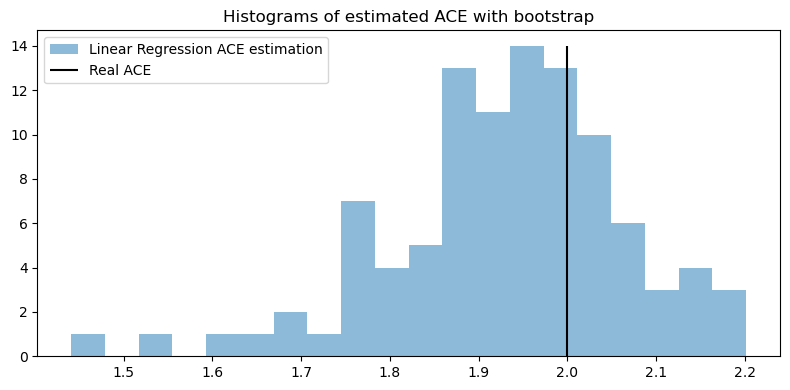

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))

hist_lr, _, _ = ax.hist(cace_distribution_lr, bins=20, alpha=0.5, label="Linear Regression ACE estimation")

min_hist = min(hist_lr)
max_hist = max(hist_lr)
ax.vlines(2, min_hist, max_hist, "k", label="Real ACE")

ax.legend()
ax.set_title("Histograms of estimated ACE with bootstrap")
plt.tight_layout()

___